
## Logistic Regression as a Method of Predicting NCAA Men's Basketball Tournament Games

#### Bernard Chang
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


### Executive Summary


Logistic regression is a powerful classification algorithm that can be used to predict the likelihood of a binary outcome from a set of independent variables. In this workflow, I present the logistic regression algorithm and exemplify the method by predicting the outcomes of NCAA Men's basketball games. Using logistic regression with just two box-score statistics leads to a substantial improvement in the prediction F1 score over a "baseline" model created by blindly selecting winners using assigned tournament seedings (generally, higher seeds indicate the better team). This regression method proves to be a relatively simple, robust way to make accurate predictions on basketball games. Further work should be done refining the feature space and comparing to more complex methods such as creating a neural network.

### Import Packages

In the following cell, the required packages for this workflow are imported. These are organized under system, data manipulation, visualization, and machine learning packages. 

In [1]:
# System packages
import os

# Data structures, IO, and matrix manipulation packages
import pandas as pd
import numpy as np


# Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython import display

# ML Packages from sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

### Functions

In [2]:
##################################################################
# A function that performs splitting training and validation split, 
# then standardizes the predictor features
# Inputs= Training dataset, features, and year to split (Default 2015)
# Returns= Train_x, train_y: Predictor and response features from year_to_split to 2018
##################################################################

def train_split(data_df, features, year_to_split=2015):
    seasons = data_df['Season'].unique()
    
    std_scaler = StandardScaler()
    
    train_x = data_df.loc[data_df['Season'] >= year_to_split , features]
    train_x = train_x.loc[data_df['Season'] < 2019 , features]
    
    train_y = data_df.loc[data_df['Season'] >= year_to_split, ['Win_A']]
    train_y = train_y.loc[data_df['Season'] < 2019, ['Win_A']].to_numpy().ravel()
    train_x = std_scaler.fit_transform(train_x)
    
    return train_x, train_y, std_scaler

### Load Data

To exemplify the logistic regression method, this workflow uses data that is openly available for the "March Machine Learning Mania 2021 - NCAAM" competition on [kaggle.com](https://www.kaggle.com/c/ncaam-march-mania-2021/data). Details of the datasets are contained in the "Data" landing page.

Here, I will load precompiled data. For details on how the data was compiled from across multiple files, please see the ```data_compilation.ipynb``` file in my [GitHub repository](https://github.com/BC-Chang/predict-march-madness) . 

The datafile contains many columns of data, including labels for the year, teams, and box score statistics (e.g. points, assists, rebounds, turnovers, etc.).

The features that will be used in the first iteration of this workflow are as follows:

* **Tournament Seeds** - Tournment seeding for each team, for each year, as determined by the NCAA tournament selection committee; unitless
* **Difference in assists** - Difference in the number of assists between the winning and the losing teams.
* **Difference in turnovers** - Difference in the number of turnovers committed by the winning and the losing teams. 

In the following cell, I read in the training data from my GitHub repository. There are two datasets contained in the repository. The first is the training dataset I compiled with the above features. The second is the validation dataset provided in the Kaggle competition; however, I manipulated the dataset to include the same features as the training set. 

In [3]:
# Path to the repository that contains the data
repo_data_path = 'https://raw.githubusercontent.com/BC-Chang/predict-march-madness/master/draft2_data'

# Read in the train and test sets
train = pd.read_csv(f'{repo_data_path}/training_dataset.csv')
test = pd.read_csv(f'{repo_data_path}/validation_dataset.csv')

# Show the first 5 rows of the training set
train.head()

,Season,DayNum,Team_A,Score_A,Team_B,Score_B,Seed_A,Seed_B,mean_WScore_A,FGM_A,...,OR_Diff,DR_Diff,Ast_Diff,TO_Diff,Stl_Diff,Blk_Diff,PF_Diff,FG%_Diff,3P%_Diff,FT%_Diff
0,2003,134,1421,92,1411,84,16,16,79.538462,27.230769,...,0.057692,5.822115,5.932692,-2.326923,2.802885,0.975962,-2.000000,0.076331,0.072927,0.012063
1,2003,136,1112,80,1436,51,1,16,86.200000,30.640000,...,-3.160000,4.826667,5.200000,0.133333,-0.226667,0.240000,-2.520000,0.093552,0.121070,0.043931
2,2003,136,1113,84,1272,71,10,7,80.722222,29.055556,...,0.818182,5.040404,3.671717,-0.292929,1.358586,2.878788,-2.555556,0.105679,0.008355,0.024322
3,2003,136,1141,79,1166,73,11,6,83.347826,27.956522,...,-1.782609,3.289855,5.405797,-0.536232,1.181159,1.050725,-4.666667,0.124026,0.128165,0.072128
4,2003,136,1143,76,1301,74,8,9,76.095238,27.571429,...,-2.773810,5.529762,2.416667,0.928571,1.107143,0.232143,-3.136905,0.064492,0.021723,0.069972


The test set contains the same set of features as the training set. The columns that are missing are for data labeling and are irrelevant to model training.

In [4]:
test.head()

,ID,Pred,Season,TeamID_A,TeamID_B,Seed_A,Seed_B,SeedDiff,mean_WScore_A,WFGM,...,OR_Diff,DR_Diff,Ast_Diff,TO_Diff,Stl_Diff,Blk_Diff,PF_Diff,FG%_Diff,3P%_Diff,FT%_Diff
0,2015_1107_1112,0.5,2015,1107,1112,14,2,12,67.791667,22.375,...,-1.833333,2.5,2.083333,-1.916667,0.541667,0.333333,-2.5,0.069181,0.055315,0.113591
1,2015_1107_1116,0.5,2015,1107,1116,14,5,9,67.791667,22.375,...,-1.833333,2.5,2.083333,-1.916667,0.541667,0.333333,-2.5,0.069181,0.055315,0.113591
2,2015_1107_1124,0.5,2015,1107,1124,14,3,11,67.791667,22.375,...,-1.833333,2.5,2.083333,-1.916667,0.541667,0.333333,-2.5,0.069181,0.055315,0.113591
3,2015_1107_1125,0.5,2015,1107,1125,14,15,-1,67.791667,22.375,...,-1.833333,2.5,2.083333,-1.916667,0.541667,0.333333,-2.5,0.069181,0.055315,0.113591
4,2015_1107_1129,0.5,2015,1107,1129,14,11,3,67.791667,22.375,...,-1.833333,2.5,2.083333,-1.916667,0.541667,0.333333,-2.5,0.069181,0.055315,0.113591


### Data Preprocessing

Before training our model, we should examine our data. This includes looking at summary statistics, visualization, and any data cleaning if necessary.

#### Summary Statistics

This step is used to ensure no data are missing. 
It is also useful to compare wins and losses, and training and validation datasets

##### Training Dataset

Here, we find the summary statistics of each column to ensure no data are missing and to check the scales each feature.

In [5]:
train.describe()

,Season,DayNum,Team_A,Score_A,Team_B,Score_B,Seed_A,Seed_B,mean_WScore_A,FGM_A,...,OR_Diff,DR_Diff,Ast_Diff,TO_Diff,Stl_Diff,Blk_Diff,PF_Diff,FG%_Diff,3P%_Diff,FT%_Diff
count,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,...,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03,2.230000e+03
mean,2011.096861,139.047534,1294.917040,69.490135,1294.917040,69.490135,6.980717,6.980717,77.853556,25.547570,...,2.207502e-16,2.974402e-15,-5.274107e-15,1.198842e-16,-1.516263e-15,-7.492761e-18,-2.128044e-15,-3.127948e-17,9.334835e-18,1.793676e-12
std,4.895823,4.220959,104.201408,11.980455,104.201408,11.980455,4.700838,4.700838,5.022649,3.063122,...,2.182368e+00,4.746425e+00,4.295474e+00,2.033854e+00,1.948835e+00,1.438195e+00,3.753332e+00,8.390624e-02,9.385335e-02,7.795452e-02
min,2003.000000,134.000000,1101.000000,29.000000,1101.000000,29.000000,1.000000,1.000000,64.280000,0.000000,...,-1.291176e+01,-2.672727e+01,-1.470588e+01,-1.061765e+01,-7.288462e+00,-6.882353e+00,-1.702941e+01,-4.686837e-01,-3.497164e-01,-7.286730e-01
25%,2007.000000,136.000000,1211.000000,61.000000,1211.000000,61.000000,3.000000,3.000000,74.346572,23.500000,...,-1.153846e+00,-3.875000e+00,-3.714286e+00,-1.232692e+00,-1.318182e+00,-1.021930e+00,-3.059158e+00,-7.261197e-02,-7.557640e-02,-4.056400e-02
50%,2011.000000,137.000000,1285.000000,69.000000,1285.000000,69.000000,6.000000,6.000000,77.600000,25.635789,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2015.000000,139.000000,1393.000000,77.000000,1393.000000,77.000000,11.000000,11.000000,81.275217,27.452020,...,1.153846e+00,3.875000e+00,3.714286e+00,1.232692e+00,1.318182e+00,1.021930e+00,3.059158e+00,7.261197e-02,7.557640e-02,4.056400e-02
max,2019.000000,154.000000,1463.000000,121.000000,1463.000000,121.000000,16.000000,16.000000,91.689655,34.241379,...,1.291176e+01,2.672727e+01,1.470588e+01,1.061765e+01,7.288462e+00,6.882353e+00,1.702941e+01,4.686837e-01,3.497164e-01,7.286730e-01


Here we see 2230 data entries for the training set. This is equivalent across all columns indicating that we do not have missing data. The features of interest appear to operate on different scales — the means of each column are on several different orders of magnitude, so some normalization/standardization procedure will be necessary. 

##### Test Dataset
We get the same summary statistics as for the training dataset. We see that statistics for the features of interest are comparable between the testing and training datasets. 

In [6]:
test.describe()

,Pred,Season,TeamID_A,TeamID_B,Seed_A,Seed_B,SeedDiff,mean_WScore_A,WFGM,WFGA,...,OR_Diff,DR_Diff,Ast_Diff,TO_Diff,Stl_Diff,Blk_Diff,PF_Diff,FG%_Diff,3P%_Diff,FT%_Diff
count,11390.0,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,...,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000,11390.000000
mean,0.5,2017.000000,1236.486128,1358.525637,8.826602,8.761633,0.064969,78.881415,27.552299,57.250274,...,-0.461959,4.019194,3.479147,-1.015018,1.013076,0.826760,-2.228041,0.068989,0.071525,0.032372
std,0.0,1.414276,88.035207,82.661731,4.738361,4.588366,6.644729,5.110269,2.108032,3.439532,...,1.705987,2.255468,1.800364,1.692115,1.146880,1.009024,1.959847,0.026055,0.039267,0.047590
min,0.5,2015.000000,1101.000000,1112.000000,1.000000,1.000000,-15.000000,64.280000,22.100000,45.521739,...,-6.325926,-1.533333,-0.859649,-5.468750,-2.237037,-2.033333,-7.875000,-0.007401,-0.034266,-0.128006
25%,0.5,2016.000000,1159.000000,1300.000000,5.000000,5.000000,-5.000000,75.350000,26.217391,55.000000,...,-1.483696,2.680000,2.291304,-2.171946,0.233333,0.142857,-3.333333,0.051850,0.045887,0.001742
50%,0.5,2017.000000,1234.000000,1374.000000,9.000000,9.000000,0.000000,78.800000,27.473684,57.357143,...,-0.545455,4.003759,3.400000,-1.000000,1.008772,0.781818,-2.165217,0.069722,0.072105,0.032132
75%,0.5,2018.000000,1300.000000,1433.000000,13.000000,12.000000,5.000000,82.350000,28.772727,59.550000,...,0.417024,5.205000,4.400000,0.038462,1.712551,1.438596,-1.259259,0.086950,0.094911,0.061836
max,0.5,2019.000000,1462.000000,1463.000000,16.000000,16.000000,15.000000,93.833333,34.241379,67.111111,...,12.911765,25.264706,14.705882,10.617647,6.558824,6.882353,17.029412,0.154853,0.215127,0.193705


The counts of the data columns are consistent, meaning we are not missing data. The reason why the counts for the testing dataset are significantly higher than that of the training dataset is because the testing dataset contains game-by-game statistics between two teams, whereas the training set contains the average for each team over the entire season/tournament.

#### Data Visualization

Here we visualize the data to better evaluate the relationships between features. I plot the univariate description of both the training and testing data in the form of a histogram. I also plot each potential relevant feature against the win/loss ratio for each team. This could help identify correlations between the box score statistic and wins/losses.


Dropdown(description='Statistic', index=13, options=('Seed_A', 'Seed_B', 'mean_WScore', 'FGM', 'FGA', 'FGM3', …

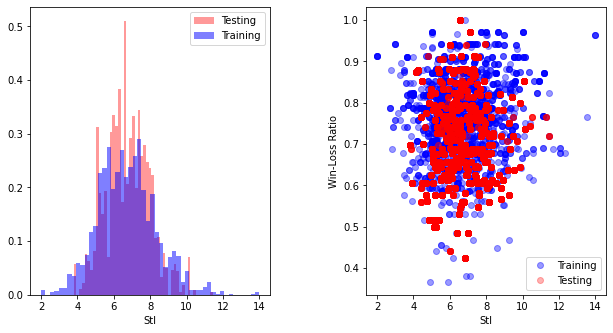

In [7]:
# Obtain the column headings of the relevant features of interest of the training set. 
train_keys = [*train.keys()][6:26]

# Clean up the column titles for dropdown menu selection
labels = train_keys.copy()
labels[2:] = [key.rsplit('_', 1)[0] for key in train_keys[2:]]

# Create dictionary between dropdown menu choices and training set column headings
train_keys_dict = {labels[i]: train_keys[i] for i in range(len(labels))}

# Obtain the column headings of the relevant features of interest of the testing set. 
test_keys = [*test.keys()][5:26]
test_keys.remove('SeedDiff')

# Create dictionary between dropdown menu choices and testing set column headings
test_keys_dict = {labels[i]: test_keys[i] for i in range(len(labels))}

# Create a dropdown menu widget in IPython for user interaction
w = widgets.Dropdown(
    options = labels,
    description = 'Statistic')

# A function that plots a histogram and a scatterplot of the selected feature.
def plot_stats(*args):
    # Reset the IPython widget display
    display.clear_output(wait=True)
    display.display(w)
    
    # Plot the histogram of the feature of interest in the test set
    plt.figure(figsize=(8,5))
    plt.subplot(1,2,1)
    test_key = test_keys_dict[w.value]
    plt.hist(test[test_key][test[test_key] != 0], bins=50, color='r', alpha=0.4, label='Testing', density=True)
    # Plot the histogram of the feature of interest in the training set
    train_key = train_keys_dict[w.value]
    plt.hist(train[train_key][train[train_key] != 0], bins=50, color='b', alpha=0.5, label='Training', density=True)
    plt.xlabel(w.value)
    plt.legend()
    
    # Plot the scatter plot of the win/loss ratio vs. the selected feature of interest
    plt.subplot(1,2,2)
    plt.plot(train[train_key][train[train_key] != 0], train['WL_A'][train[train_key] != 0], 'bo', alpha=0.4, label='Training')
    plt.plot( test[test_key][test[test_key] != 0], test['WL_A'][test[test_key] != 0], 'ro', alpha=0.3, label='Testing')
    plt.xlabel(w.value)
    plt.ylabel('Win-Loss Ratio')
    plt.legend()
    
    plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.9, wspace=0.4, hspace=0.4)
    

# Display and update interactive plot
display.display(w)
plot_stats(w.value)
w.observe(plot_stats, 'value')

Observing the histograms, each box score statistic are approximately normally distributed. This indicates that standardization is an appropriate method of rescaling the data for training. Moreover, the training dataset is adequately representative of the testing dataset. 

The scatterplot shows a "shotgun blast" pattern between each box score statistic and a team's win-loss ratio. There are no discernable trends between any feature and a team's win/loss ratio. This is further supported by the pair-wise correlation matrix shown in the following cell. 

<AxesSubplot:>

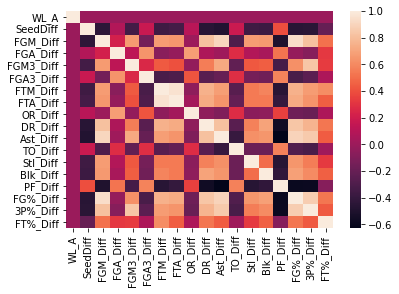

In [8]:
# Calculate the pairwise correlation matrix of all features
training_corr_matrix = train.loc[:,
                                 ['WL_A','SeedDiff', 'FGM_Diff',
                                 'FGA_Diff','FGM3_Diff','FGA3_Diff',
                                 'FTM_Diff','FTA_Diff','OR_Diff',
                                 'DR_Diff','Ast_Diff','TO_Diff',
                                 'Stl_Diff','Blk_Diff','PF_Diff',
                                 'FG%_Diff','3P%_Diff','FT%_Diff']].corr()

# Plot the heatmap of the correlation matrix.
sns.heatmap(training_corr_matrix)

From the correlation matrix, we see that no feature is strongly correlated with the Win-Loss Ratio (WL_A).

### Feature Selection

For conciseness, I do not show my feature selection here. The features I will use to exemplify the logistic regression method are differences in the number of assists and the number of turnovers committed by each team. Fitting the model with these features will be compared to the naive prediction using only the assigned tournament seeds.

### Logistic Regression

In its most basic form, logistic regression is used to model a binary dependent variable. In other words, it can be used to model the probability of an event such as a yes/no, win/loss, or pass/fail occurring based on one or more explanatory features.

Binary logistic regression assumes the following:
 1. The dependent variable is dichotomous — The final prediction fits into one of two categorical values (e.g., win/loss).
     - This example predicts whether a team wins or loses a matchup based on their regular season statistics. Therefore, the response variable is binary (win or loss). 
 
 2. No multicollinearity between predictor variables — The predictor variables should be independent (or nearly independent of each other). 
     - This is checked for in the correlation matrix in the previous sections. Our predictor features, assists and turnovers, do not have a high correlation.

 3. The predictor variables are linearly related to the logit of the response variable.
     - Logits are the ratio of an event occurring to the event not occurring. 
         - $\text{Logit}(p) = \text{log}(\frac{p}{1-p})$, where p = probability of a positive outcome
         
 4. Training set sample size is sufficiently large — The training set size is large enough to draw valid conclusions from the fitted regression model.
 
 5. Observations are independent of each other.
 
 6. No extreme outliers.
 
 
#### Governing Equation 
In practice, logistic regression operates similarly to linear regression. The logistic regression is modeled by:

$$ \text{log}\left( \frac{\pi}{1 - \pi} \right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... \beta_m x_m = \hat{y}$$

where, $\pi$ indicates the probability of an event, $\beta_i$ are the regression coefficients, and $x_i$ are the explanatory variables.

Intuitively, logistic regression applies the Sigmoid function to the raw output of a linear model to predict the probability of an event occurring.

Logistic Regression is useful for classifying categorical. In our case, we can classify the team as a win or a loss for its matchup based on the features. It's flexible in that it can take in any number of input features and also has some built-in feature selection, similarly to LASSO ordinary linear regression.

The following code cell demonstrates how transforming the raw output of a linear model with the sigmoid function can be used to predict an event occurring


RadioButtons(description='Activation:', options=('sigmoid', 'linear'), value='sigmoid')

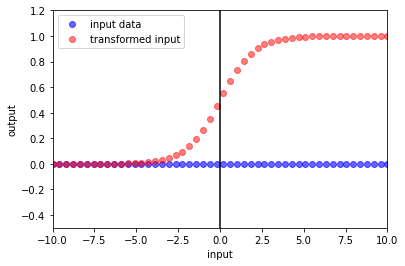

In [9]:
##########################################################################################################
# This interactive widget demonstrates how the sigmoid function transforms raw linear input data
# The widget is adapted from a machine learning workshop I gave to my research group's industry affiliates
# See citation in the last cell.
##########################################################################################################

# Initialize selection options in widget
act = widgets.RadioButtons()
act.options=['sigmoid','linear']
act.description = 'Activation:'
display.display(act)

# A function to plot the sigmoid function
def plot_sigmoid(*args):
    # Initialize the range of input data
    xi = [-10, 10]
    x_t = np.linspace(xi[0],xi[1])
    
    # Calculate linear transformation of the data
    y_t = x_t*1+0
    lim = ([-50, 50])
    
    # Calculate the sigmoid transformation
    if act.value=='sigmoid':
        y_t = 1 / (1 + np.exp(-y_t))
        lim = ([-0.5, 1.2])
    
    # Plot and display transformed data
    display.clear_output(wait=True)
    display.display(act)
    plt.plot(x_t, np.zeros_like(x_t), 'bo', alpha=0.6)
    plt.plot(x_t, y_t, 'ro', alpha=0.5)
    plt.plot([0,0],lim, 'k-')
    plt.ylim(lim)
    plt.xlim([-10 ,10])
    plt.legend(['input data','transformed input'])
    plt.xlabel('input')
    plt.ylabel('output')
    plt.show()

# Call the above function
plot_sigmoid()

# Update display based on user selection
act.observe(plot_sigmoid,'value')


As shown in the widget in the previous cell, the Sigmoid function is a non-linear activation function commonly used in machine learning. The key to logistic regression is that it applies the sigmoid function to transform the input data (shown in blue) to a value between 0 and 1. In other words, the function returns the probability that $y = 1$ given $x$, parameterized by $\beta$. This is in contrast to the linear function where there are no theoretical bounds to the transformed data.

In decision boundary is highlighted by the vertical line and is described as follows:

 - Predict 1 if $\beta^T x \ge 0 \rightarrow h(x) \ge 0.5$ 
  
 - Predict 0 if $\beta^T x \le 0 \rightarrow h(x) \le 0.5$ 
 
 
#### Cost Function

In linear regression, we minimize the least squared error. However, using LSE in logistic regression results in a non-convex graph with local minimums and is therefore an unsuitable loss function. Instead, this method minimizes the **logistic loss**:


$$ \text{Cost}(\hat{y}, y) \begin{cases}
    -\text{log}(\hat{y}) & \text{if } y = 1 \\
    -\text{log}(1 - \hat{y}) & \text{if } y = 0
    \end{cases} $$


The following cell visualizes the logistic loss for cases in which the team wins (y = 1) and the team loses (y = 0). This is to gain a better intuitive understanding of how the loss functions behave.

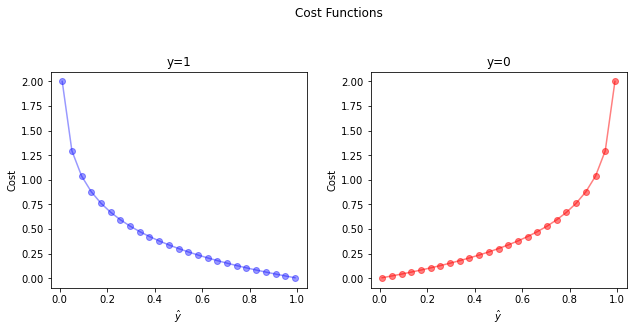

In [10]:
# Initialize the input range
x = np.linspace(0.01,0.99,25)

# Calculate the cost function for the two cases
cost_0 = -np.log10(1-x)
cost_1 = -np.log10(x)

# Plot the cost functions
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.plot(x, cost_1, '-ob', alpha=0.4)
plt.xlabel('$\hat{y}$')
plt.ylabel('Cost')
plt.title('y=1')
plt.subplot(1,2,2)
plt.plot(x,cost_0, '-or', alpha=0.5)
plt.xlabel('$\hat{y}$')
plt.ylabel('Cost')
plt.title('y=0')
plt.subplots_adjust(left=0, right=1, bottom= 0.2, top=0.8, wspace=0.25, hspace=0)
plt.suptitle('Cost Functions');

From the above plots, we intuitively see that the cost functions more heavily penalize predicting 0 when the true value is 1 and vice versa than if the fitted models are closer to the true values. 

This cost function is further advantageous in that it can be written as a single formula:

$$ \text{Cost}(\hat{y}, y) = -y\text{log}(\hat{y}) - (1-y)\text{log}(\hat{y}) + \text{Regularization term}$$

The regularization term will be revisited later in this workflow. For fitting, we sum the cost function over all of the training data:

$$ \text{Cost}(\hat{y}, y) = \frac{1}{m} \sum^m_{i=1} \text{Cost}(\hat{y}_i, y_i) $$

### Baseline model

To evaluate the performance using logistic regression, I manually calculated the F1-Score of a model (not shown here) that uses only the difference in tournament seedings as predictor features. 

The F1-Score is defined as:

$$ F_1 = \frac{2}{\text{recall}^{-1} + \text{precision}^{-1}} $$

The naive model accurately predicted 90/134 outcomes, achieving an F1-Score of 0.681. 

### First Logistic Regression Model

Here, I perform a first pass of the logistic regression model. The model uses all of the Scikit-Learn defaults for hyperparameters and trains with data from 2003 – 2018.

Input features are the difference in the number of turnovers and assists committed by the teams included in a given matchup.

The model is validated with the results from the 2019 season.

In [11]:
# Get a list of the seasons (from 2003-2019)
seasons = train['Season'].unique()

# List of the input predictor features. 
# For this model, predictor features include the turnover and assist differentials between the two matchup teams.
features = [
    'SeedDiff',
    'TO_Diff',
    'Ast_Diff',
    ]

# Validate the model with the 2019 season
val_season = 2019

With the input features and validation season defined, we initialize the first logistic regression model with all Scikit-Learn defaults for model hyperparameters.

The basic workflow of the model is as follows:
 1. Split the training data into predictor and response features using the ```train_split()``` function defined above
     - The predictor features are standardized inside the ```train_split()``` function
 2. Retrieve the input and response features from the validation season (year 2019) 
     - Standardize the input features using the same standard scaler as was used in the training data
 3. Initialize the logistic regression model object using the ```LogisticRegression()``` function from Scikit-Learn 
 4. Train the model using the ```fit()``` function in Scikit-Learn
 5. Predict the outcomes of the validation dataset using the ```predict()``` function from Scikit-Learn
 6. Compute the F1-Score of the predicted outcomes vs. the true game outcomes.

In [12]:
# Seed for initializing random state of logistic regression
SEED = 110

# Train with all available data
season_split = 2003

# Split training data
train_X, train_Y, std_scaler = train_split(train, features, season_split)

# Retrieve validation data from 2019 season
val_X = train.loc[train['Season'] == val_season, features]
val_Y = train.loc[train['Season'] == val_season, ['Win_A']]

# Standardize the predictor features of the validation data
val_X = std_scaler.transform(val_X)

# Initialize the logistic regression model
model = LogisticRegression(C=10,  random_state=SEED, solver='saga', max_iter=500) #C=10,

# Fit the model to training data
model.fit(train_X, train_Y)


# Predicted 2019 outcome
y_hat = model.predict(val_X)

# Store f_score in a list
f_score = [val_season, f1_score(val_Y, y_hat)]

print(f'{f_score[0]} F1-Score: {f_score[1].round(3)}')


2019 F1-Score: 0.955


The aforementioned basic workflow was able to fit a logistic regression model and make a prediction the validation dataset with an F1-Score of 0.955, which is a substantial improvement over the baseline model.

### Tune Hyperparameters

Some hyperparameters we can play with for this problem are the amount of training data, the regularization term (L1, L2), and inverse of the regularization strength (C). I will explore each of these individually.

#### Amount of Training Data

Logistic regression is sensitive to the amount of data available for training. Sufficient data is needed to avoid overfitting the data. Too much data can cause underfitting where the model is not general enough to make accurate predictions. In the first example, we trained with all data since the year 2003. 

Here, I perform 16 realizations of the logistic regression model, sequentially add a season's-worth of training data starting from year 2018 and working back to 2013. I calculate and compare the F1-scores for each realization of the model.

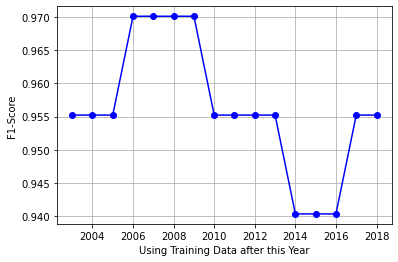

In [13]:
seasons2split = np.arange(2003, 2019, 1)

# Retrieve validation data from 2019 season
val_X = train.loc[train['Season'] == val_season, features]
val_X = std_scaler.transform(val_X)
val_Y = train.loc[train['Season'] == val_season, ['Win_A']]

f_score = []

for season_split in seasons2split:
    
    # Our logistic regression model
    model = LogisticRegression(C=10, random_state=SEED, solver='saga', max_iter=500)

    # Retrieve training data
    train_X, train_Y, std_scaler = train_split(train, features, season_split)

    # Fit the model to training data
    model.fit(train_X, train_Y)

    # Predicted 2019 outcome
    y_hat = model.predict(val_X)

    # Store f_score in a list
    f_score.append([season_split, f1_score(val_Y, y_hat)])

f_score = np.array(f_score)

plt.plot(f_score[:,0], f_score[:,1], 'o-b')
plt.xlabel('Using Training Data after this Year')
plt.ylabel('F1-Score')
plt.grid()

As evidenced by the above plot, starting the training set from years between 2005 — 2009 yields the best performing model. We see models trained with data from 2010 onward do not perform as well, indicating that the model does not have enough data. The jump we see in when using data from 2017 and 2018 is an indication that the model is overfitting. 

The drop from 2005 to 2004 could indicate that the model is "underfitting," meaning that it does not generalize to the validation data well. From a "knowledge about the data" perspective, historical data is not necessarily the best predictor of the modern game in sports as play style, tactics, and other factors change throughout time. From the statistics perspective, this would mean that the correlations between predictor and response features are not linear — violating the 3rd listed assumption of the logistic regression method.

Moving forward, we will use data from 2009 onward to fit our model.

#### Regularization Term

Regularization applies a penalty to increasing the magnitude of a parameter so that it reduces the model variance. This helps reduce the possibility of overfitting. Similar to Ridge and LASSO regression, logistic regression and the Scikit-Learn Python module for logistic regression also uses L1 (LASSO) and L2 (Ridge) norms as regularization terms. The regularized cost function is very similar in form to the ones for linear regression. 

If using L1 (Lasso) regularization, the regularized cost function becomes:
$$ \text{Cost}(\hat{y}, y) = \frac{1}{m} \sum^m_{i=1} \text{Cost}(\hat{y}_i, y_i)  + C \sum_{j=1}^n|\beta_j|$$

If using L2 (Ridge) regularization, the regularized cost function is:
$$ \text{Cost}(\hat{y}, y) = \frac{1}{m} \sum^m_{i=1} \text{Cost}(\hat{y}_i, y_i)  + C \sum_{j=1}^n\beta_j^2$$


Similarly to ordinary linear regression, the L1 regularization term also contains an implicit feature selection. LASSO regularization will zero-out the influence of "less important" features (i.e., the coefficients of these terms become 0). 

In the first example, we used the default L2 regularized cost function. Here we cycle through different regularization norms, including no regularization, L1, L2, and a combination of L1 and L2 (elasticnet).

Text(0, 0.5, 'F1-Score')

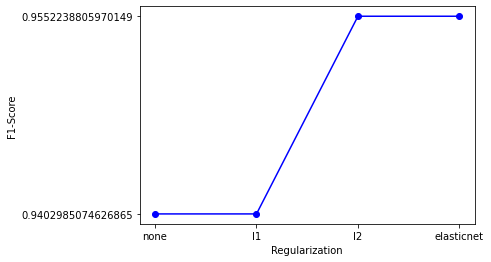

In [14]:
import warnings
warnings.filterwarnings('ignore')

# Regularization terms to try
reg_term = ['none','l1','l2','elasticnet']

# Train with all data prior to and including season_split
season_split = 2009

# Retrieve validation data from 2019 season
val_X = train.loc[train['Season'] == val_season, features]
val_X = std_scaler.transform(val_X)
val_Y = train.loc[train['Season'] == val_season, ['Win_A']]

f_score = []


for regularization in reg_term:
    
    # Our logistic regression model
    model = LogisticRegression(C=10, random_state=SEED, penalty=regularization, solver='saga', l1_ratio=0.5, max_iter=1000)

    # Fit the model to training data
    model.fit(train_X, train_Y)

    # Predicted 2019 outcome
    y_hat = model.predict(val_X)

    # Store f_score in a list
    f_score.append([regularization, f1_score(val_Y, y_hat)])

# f_score
f_score = np.array(f_score)

plt.plot(f_score[:,0], f_score[:,1], 'o-b')
plt.xlabel('Regularization')
plt.ylabel('F1-Score')

We see that the L2 and L1/L2 combination (elasticnet) regularization produces the best models for a regularization strength of 1. In this model, the elasticnet regularization term assumes equal contributions from the L1 and L2 norms. The model performance is not sensitive to the relative contributions of the norms (section omitted for conciseness).

In this example, elasticnet regularization involves extra terms in the cost function (added complexity) with no model performance benefit; therefore, I will continue with the L2 norm as the regularization term. 

#### Inverse of regularization strength

Here we vary the inverse of the regularization strength, ```C```, seen as the coefficient of the regularization term in the cost function. This is similar to the $\lambda$ term used in Ridge and LASSO regression. Smaller values specify greater relative influence of the regularization term over the logistic loss function. 

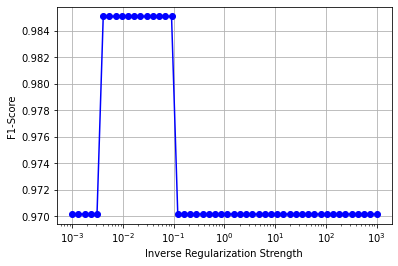

In [15]:
reg_strength = np.logspace(-3,3, 50)

# Train with all data prior to and including season_split
season_split = 2009

# Retrieve validation data from 2019 season
val_X = train.loc[train['Season'] == val_season, features]
val_X = std_scaler.transform(val_X)
val_Y = train.loc[train['Season'] == val_season, ['Win_A']]
f_score = []

for c in reg_strength:
    
    # Our logistic regression model
    model = LogisticRegression(C=c, random_state=SEED, penalty='l2', solver='saga')

    # Retrieve training data
    train_X, train_Y, std_scaler = train_split(train, features, season_split)
    
    # Fit the model to training data
    model.fit(train_X, train_Y)

    # Predicted 2019 outcome
    y_hat = model.predict(val_X)

    # Store f_score in a list
    f_score.append([c, f1_score(val_Y, y_hat)])

f_score = np.array(f_score)

plt.semilogx(f_score[:,0], f_score[:,1], 'o-b')
plt.xlabel('Inverse Regularization Strength')
plt.ylabel('F1-Score')
plt.grid()

Here we see a ```C``` value between $10^{-2}$ and $10^{-1}$ maximizes the F1-score of the fitted model. For the tuned model, I will use an inverse regularization strength of $5 * 10^{-2}$.

We see that if the regularization strength is too high (```C``` is too small), the model tends to overfit, thus giving a poorer model performance. When the regularization strenght is too low (```C``` is too high), the contribution of the regularization term is not large enough to compensate for variance in the base model, also leading to poorer model performance.

### Final Model

We retrain our model with the tuned hyperparameters to get our final model. 

This still follows the previously described workflow of:
 1. Splitting training data contained in years 2009-2018 and standardizing predictor features
 2. Standardizing validation predictor features
 3. Initializing the logistic regression model with the tuned hyperparameters
 4. Fitting the logistic regression model with the training data
 5. Evaluating the model with the validation dataset and calculating the F1-Score

In [16]:
# Seed for initializing random state of logistic regression
SEED = 110

# Train with all data prior to and including season_split
season_split = 2009

# Retrieve training data
train_X, train_Y, std_scaler = train_split(train, features, season_split)

# Retrieve validation data from 2019 season
val_X = train.loc[train['Season'] == val_season, features]
val_X = std_scaler.transform(val_X)
val_Y = train.loc[train['Season'] == val_season, ['Win_A']]

# Our logistic regression model
model = LogisticRegression(C=5E-2, random_state=SEED, penalty='l2', solver='saga', max_iter=200)


# Fit the model to training data
model.fit(train_X, train_Y)



# Predicted 2019 outcome
y_hat = model.predict(val_X)

# Store f_score in a list
f_score = [val_season, f1_score(val_Y, y_hat)]
print(f'{f_score[0]} F1-Score: {f_score[1]}')

2019 F1-Score: 0.9850746268656716


### Results

From our validation prediction, we get a final F1-Score of 0.985. This is a substantial improvement over the baseline model. Via hyperparameter tuning, the F1-score was able to improve from 0.955 over the untuned model.

Here, I construct a confusion matrix to visualize the performance of this classification model. The confusion matrix communicates the numbers of true positives, true negatives, false positives, and false negatives. In terms of our model, these correspond to correctly predicting winners, correctly predicting losers, predicting wins when losses occurred, and predicting losses when wins occurred, respectively.

<AxesSubplot:>

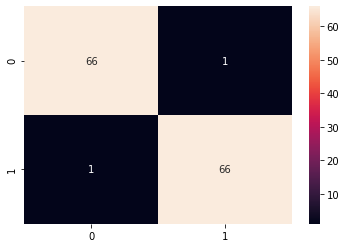

In [17]:
# Calculate the confusion matrix using the function from the SKlearn library
cm = confusion_matrix(val_Y, y_hat)

# Visualize the confusion matrix using a Seaborn heatmap
sns.heatmap(cm, annot=True)

### Discussion of Results and Workflow Summary

This project outlines the general workflow of performing binary logistic regression for classification using multiple predictor features. The logistic regression model is most useful when the response variable is categorical and dichotomous. The workflow was exemplified by attempting to predict the outcomes of the 2019 NCAA Men's basketball tournament games using three features: the difference in tournament seeds, number of assists, and number of turnovers committed. 

Overall, in the context of machine learning, this logistic regression workflow is simple to implement compared to other more complex models such as designing and training a neural network. This workflow demonstrates that binary logistic regression is able to adequately predict the outcomes of matchups based on few input predictor features, where the simple model saw substantial improvement over the baseline model described. 

Some pitfalls of logistic regression are that it assumes linearity between the response and predictor variables. In reality, there is often ambiguity in the relationships between features. This should be more carefully considered in the feature selection process than what was demonstrated here.

As with many other methods covered in this course, logistic regression is not very accurate if the sample size is too small. Though this was not a problem for this example and in the context of college basketball where a slew of sports data analytics are available, this could be an issue in other applications where data collection is more sparse. 

Logistic regression is an extremely robust method, which allows for multiple predictor variables to be considered simultaneously. While the model is simple to implement, domain expertise is still required as to avoid blindly feed the model raw data. Doing so quickly increases the model complexity, oftentimes leading to poor model performance. A more comprehensive approach to feature selection should be employed. Also, more work should be done comparing this relatively simple model to a more complex implementation such as using a neural network.


I hope this was helpful,

Bernard Chang

### Citations:

Chang, B. (2021). predict-march-madness. GitHub Repository. Retrieved December 1, 2021, from https://github.com/BC-Chang/predict-march-madness

Chang, B., Santos, J., et al. (2021). ms-net-workshop. GitHub Repository. Retrieved December 1, 2021, from https://github.com/BC-Chang/ms-net-workshop

Harris, C. R, et al. (2020). Array programming with NumPy. Nature, 585(7825), 357–362.

Hunter, J. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90–95.

Kaggle. (2021). March Machine Learning Mania 2021 - NCAAM. Retrieved December 1, 2021 from https://www.kaggle.com/c/ncaam-march-mania-2021/overview.

Luo, S. (2019). Optimization: Loss function under the hood (part II). Medium. Retrieved December 1, 2021, from https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-ii-d20a239cde11.

McKinney, W. (2010). Data Structures for Statistical Computing in Python. In S. van der Walt & J. Millman (Reds), Proceedings of the 9th Python in Science Conference (bll 56–61). doi:10.25080/Majora-92bf1922-00a

Nagpal, A. (2017, October 14). L1 and L2 regularization methods. Medium. Retrieved December 1, 2021, from https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c. 

Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825–2830.

Sperandei S. (2014). Understanding logistic regression analysis. Biochemia medica, 24(1), 12–18. https://doi.org/10.11613/BM.2014.003

Thanda, A. (2021). What is logistic regression? A beginner's guide [2021]. CareerFoundry. Retrieved December 1, 2021, from https://careerfoundry.com/en/blog/data-analytics/what-is-logistic-regression/. 

The pandas development team (2020). pandas-dev/pandas: Pandas (Version 1.3.2). doi:10.5281/zenodo.3509134

Waskom, M. L. (2021). seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021.

Zach. (2020). The 6 assumptions of logistic regression (with examples). Statology. Retrieved December 1, 2021, from https://www.statology.org/assumptions-of-logistic-regression/. 


___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
